In [1]:
!pip install -U vnstock

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.9/120.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 10.8 MB/s eta 0:00:00


In [2]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=cde6dc9ba9a950d22bc6d68487312352236c635897031fa0b0961aef1c469328
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [3]:
pip install tensorflow

In [4]:
!pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=cb44d2453bdfbc3994ccb9bf7ceae43c5043b8b67fdcc39854aaa135a56196ee
  Stored in directory: /root/.cache/pip/wheels/46/f9/96/709295c836133071c12a300729fed4027757f889c01695feea
Successfully built keras-self-attention


In [5]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [24]:
import numpy as np
import pandas as pd
from ta.momentum import RSIIndicator
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, RNN, concatenate
from tensorflow.keras.optimizers import RMSprop
from vnstock import *
from ta.volatility import BollingerBands
from tensorflow.keras.layers import Layer
import tensorflow as tf
from keras.layers import Input, Conv1D, MaxPooling1D, Bidirectional, Flatten, BatchNormalization
from sklearn.model_selection import RandomizedSearchCV
# from scikeras.wrappers import KerasClassifier

from ta.momentum import StochasticOscillator
from ta.volume import OnBalanceVolumeIndicator
from ta.trend import CCIIndicator
from sklearn.preprocessing import StandardScaler
from ta.volume import ChaikinMoneyFlowIndicator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import regularizers
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.base import BaseEstimator, ClassifierMixin
from tensorflow.keras.saving import register_keras_serializable
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [26]:
from vnstock import *
import pandas as pd
import os
from collections import Counter
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

In [8]:
def load_stock(symbol, folder_path='stock_data'):
    """
    Load dữ liệu cổ phiếu từ mã cổ phiếu, sử dụng đường dẫn thư mục cố định.

    Parameters:
        symbol (str): Mã cổ phiếu (ví dụ: 'VCB')
        folder_path (str): Thư mục chứa file Excel (mặc định là 'stock_data')

    Returns:
        DataFrame chứa dữ liệu cổ phiếu.
    """
    file_path = os.path.join(folder_path, f"{symbol}.xlsx")

    if not os.path.exists(file_path):
        raise FileNotFoundError(f"❌ Không tìm thấy file: {file_path}")

    try:
        df = pd.read_excel(file_path)
        print(f"✅ Đã load dữ liệu cho mã: {symbol}")
        return df
    except Exception as e:
        print(f"❌ Lỗi khi load dữ liệu {symbol}: {e}")
        return pd.DataFrame()

In [10]:
df_vhm = load_stock('VNM','/content/drive/MyDrive/thacsi/LuanVan/PredictStock/TA/v1/train_data')

✅ Đã load dữ liệu cho mã: VNM


In [11]:
df_vhm

,time,open,high,low,close,volume,ticket
0,2019-01-02,77.47,79.07,77.15,79.07,403570,VNM
1,2019-01-03,79.07,79.07,77.54,78.37,449730,VNM
2,2019-01-04,78.11,79.70,77.15,79.70,498470,VNM
3,2019-01-07,81.43,83.53,80.02,83.53,897430,VNM
4,2019-01-08,83.79,83.79,82.06,82.89,448350,VNM
...,...,...,...,...,...,...,...
1013,2023-01-19,73.47,74.11,72.75,73.93,2628489,VNM
1014,2023-01-27,74.02,74.47,72.38,72.75,2333482,VNM
1015,2023-01-30,72.75,72.75,72.20,72.20,1614712,VNM
1016,2023-01-31,72.02,72.29,69.93,70.11,4819134,VNM


In [12]:
def load_and_process_data(symbol, drop_na=True, file_path = ''):
    data = load_stock(symbol,file_path)
    if data.empty:
        return None

    df = data

     # Tính toán khối lượng trung bình
    volume_ma_period = 20  # Ví dụ: khối lượng trung bình 20 ngày
    df['volume_ma'] = df['volume'].rolling(window=volume_ma_period).mean()


    # Tính tỷ lệ khối lượng hiện tại / khối lượng trung bình
    df['volume_to_volume_ma_ratio'] = df['volume'] / df['volume_ma']


    # Tính toán EMA ngắn hạn (12 ngày)
    df['ema_12'] = df['close'].ewm(span=12, adjust=False).mean()


    # Tính toán EMA dài hạn (26 ngày)
    df['ema_26'] = df['close'].ewm(span=26, adjust=False).mean()

    # Tính toán SMA trung hạn (20 ngày)
    df['sma_20'] = df['close'].rolling(window=20).mean()

    # Tính toán SMA dài hạn (50 ngày)
    df['sma_50'] = df['close'].rolling(window=50).mean()

     # Tính toán ROC

    # df['roc_1'] = ((df['close'] - df['close'].shift(1)) / df['close'].shift(1)) * 100
    df['roc_5'] = ((df['close'] - df['close'].shift(5)) / df['close'].shift(5)) * 100
    # df['roc_9'] = ((df['close'] - df['close'].shift(9)) / df['close'].shift(9)) * 100

    # Tính toán %K (Stochastic Oscillator)
    stoch_period = 14
    df['%K'] = ((df['close'] - df['low'].rolling(window=stoch_period).min()) /
                (df['high'].rolling(window=stoch_period).max() - df['low'].rolling(window=stoch_period).min())) * 100

    # Tính toán %R (Williams %R)
    df['%R'] = ((df['high'].rolling(window=stoch_period).max() - df['close']) /
                (df['high'].rolling(window=stoch_period).max() - df['low'].rolling(window=stoch_period).min())) * -100

    # Tính toán CCI (Commodity Channel Index)
    cci_period = 20
    df['typical_price'] = (df['high'] + df['low'] + df['close']) / 3
    df['cci'] = CCIIndicator(high=df['high'], low=df['low'], close=df['close'], window=cci_period).cci()

    # Tính toán OBV (On Balance Volume)
    df['obv'] = OnBalanceVolumeIndicator(close=df['close'], volume=df['volume']).on_balance_volume()


    # Tính toán MACD
    df['macd'] = df['ema_12'] - df['ema_26']
    # Tính toán Signal line (EMA 9 ngày của MACD)
    df['signal_line'] = df['macd'].ewm(span=9, adjust=False).mean()
    # Tính toán MACD histogram
    df['macd_histogram'] = df['macd'] - df['signal_line']


    # Tính toán RSI
    rsi_period = 14
    df['rsi'] = RSIIndicator(df['close'], window=rsi_period).rsi()


    # Bollinger Bands
    indicator_bb = BollingerBands(close=df['close'], window=20, window_dev=2)
    df['bb_bbm'] = indicator_bb.bollinger_mavg()
    df['bb_bbh'] = indicator_bb.bollinger_hband()
    df['bb_bbl'] = indicator_bb.bollinger_lband()
    df['bb_bbp'] = indicator_bb.bollinger_pband()

    df['bb_bbh_bb_bbl_ratio'] = df['bb_bbh'] / df['bb_bbl']


    # Xứ lý với VNINDEX
    data_time = data['time']

    data_vnd = load_stock('VNINDEX', file_path)
    data_vnd = data_vnd.drop(columns=['ticket'])
    data_vnd.columns = ['time','open_vnd', 'high_vnd', 'low_vnd', 'close_vnd', 'volume_vnd']


    # Tính toán RSI
    rsi_period = 14
    data_vnd['rsi_vnd'] = RSIIndicator(data_vnd['close_vnd'], window=rsi_period).rsi()
    # Tính toán RSI-base-MA
    ma_period = 9
    data_vnd['rsi_base_ma_vnd'] = data_vnd['rsi_vnd'].rolling(window=ma_period).mean()
    data_vnd['rsi_rsi_base_ma_ratio_vnd'] = data_vnd['rsi_vnd'] / data_vnd['rsi_base_ma_vnd']

    # Tính toán khối lượng trung bình
    volume_ma_period = 20  # Ví dụ: khối lượng trung bình 20 ngày
    data_vnd['volume_ma_vnd'] = data_vnd['volume_vnd'].rolling(window=volume_ma_period).mean()
    # Tính tỷ lệ khối lượng hiện tại / khối lượng trung bình
    data_vnd['volume_to_volume_ma_ratio_vnd'] = data_vnd['volume_vnd'] / data_vnd['volume_ma_vnd']

    # Bollinger Bands
    indicator_bb = BollingerBands(close=data_vnd['close_vnd'], window=20, window_dev=2)
    data_vnd['bb_bbm_vnd'] = indicator_bb.bollinger_mavg()
    data_vnd['bb_bbh_vnd'] = indicator_bb.bollinger_hband()
    data_vnd['bb_bbl_vnd'] = indicator_bb.bollinger_lband()
    data_vnd['bb_bbp_vnd'] = indicator_bb.bollinger_pband()

    data_vnd['bb_bbh_bb_bbl_ratio_vnd'] = data_vnd['bb_bbh_vnd'] / data_vnd['bb_bbl_vnd']

    # Tính toán ROC
    roc_period = 9  # Chu kỳ 9 ngày, bạn có thể thay đổi tùy ý
    data_vnd['roc_vnd'] = ((data_vnd['close_vnd'] - data_vnd['close_vnd'].shift(roc_period)) / data_vnd['close_vnd'].shift(roc_period)) * 100

    # Tính toán %K (Stochastic Oscillator)
    stoch_period = 14
    data_vnd['%K_vnd'] = ((data_vnd['close_vnd'] - data_vnd['low_vnd'].rolling(window=stoch_period).min()) /
                (data_vnd['high_vnd'].rolling(window=stoch_period).max() - data_vnd['low_vnd'].rolling(window=stoch_period).min())) * 100

    # Tính toán %R (Williams %R)
    data_vnd['%R_vnd'] = ((data_vnd['high_vnd'].rolling(window=stoch_period).max() - data_vnd['close_vnd']) /
                (data_vnd['high_vnd'].rolling(window=stoch_period).max() - data_vnd['low_vnd'].rolling(window=stoch_period).min())) * -100

    # Tính toán CCI (Commodity Channel Index)
    cci_period = 20
    data_vnd['typical_price_vnd'] = (data_vnd['high_vnd'] + data_vnd['low_vnd'] + data_vnd['close_vnd']) / 3
    data_vnd['cci_vnd'] = CCIIndicator(high=data_vnd['high_vnd'], low=data_vnd['low_vnd'], close=data_vnd['close_vnd'], window=cci_period).cci()

    # Tính toán OBV (On Balance Volume)
    data_vnd['obv_vnd'] = OnBalanceVolumeIndicator(close=data_vnd['close_vnd'], volume=data_vnd['volume_vnd']).on_balance_volume()

    # Tính toán EMA ngắn hạn (12 ngày)
    data_vnd['ema_12_vnd'] = data_vnd['close_vnd'].ewm(span=12, adjust=False).mean()

    # Tính toán EMA dài hạn (26 ngày)
    data_vnd['ema_26_vnd'] = data_vnd['close_vnd'].ewm(span=26, adjust=False).mean()

    # Tính toán SMA trung hạn (20 ngày)
    data_vnd['sma_20_vnd'] = data_vnd['close_vnd'].rolling(window=20).mean()

    # Tính toán SMA dài hạn (50 ngày)
    data_vnd['sma_50_vnd'] = data_vnd['close_vnd'].rolling(window=50).mean()

    data_vnd['time'] = pd.to_datetime(data_vnd['time']).dt.date
    # merge
    df['time'] = pd.to_datetime(df['time']).dt.date
    df = pd.merge(df, data_vnd, on='time')


     # Tính tỷ lệ thay đổi giá
    threshold=0.01
    df['change'] = (df['close'].shift(-1) - df['close']) / df['close']

    # Gán nhãn
    df['target'] = 0  # Hold mặc định
    df.loc[df['change'] > threshold, 'target'] = 1   # Buy
    df.loc[df['change'] < -threshold, 'target'] = 2  # Sell

    if drop_na:
        df.dropna(inplace=True)

    return df

In [14]:
df_vhm_process = load_and_process_data("VHM", file_path= '/content/drive/MyDrive/thacsi/LuanVan/PredictStock/TA/v1/train_data')

✅ Đã load dữ liệu cho mã: VHM
✅ Đã load dữ liệu cho mã: VNINDEX


In [15]:
df_vhm_process

,time,open,high,low,close,volume,ticket,volume_ma,volume_to_volume_ma_ratio,ema_12,...,%R_vnd,typical_price_vnd,cci_vnd,obv_vnd,ema_12_vnd,ema_26_vnd,sma_20_vnd,sma_50_vnd,change,target
49,2019-03-19,69.17,69.31,68.08,68.44,1100900,VHM,1047159.50,1.051320,67.416190,...,-16.150082,1008.440000,117.650607,1911916753,997.995388,980.523935,992.3235,944.8256,-0.019141,2
50,2019-03-20,67.79,68.00,66.26,67.13,1061950,VHM,1059478.00,1.002333,67.372161,...,-27.768933,999.190000,43.505368,1731871123,998.657636,982.136977,993.9095,947.0366,-0.043349,2
51,2019-03-21,67.71,67.71,64.22,64.22,1009930,VHM,1049481.00,0.962314,66.887213,...,-98.673500,989.976667,-34.242716,1549163093,996.061077,982.110534,993.6200,949.1078,0.032856,1
52,2019-03-22,64.80,66.40,64.07,66.33,957080,VHM,1049787.50,0.911689,66.801488,...,-77.687444,986.693333,-60.237723,1700974173,994.930142,982.599383,993.6100,951.2640,-0.023066,2
53,2019-03-25,65.16,65.16,63.71,64.80,793070,VHM,1047539.00,0.757079,66.493567,...,-89.326633,970.453333,-164.581097,1523341503,991.105504,981.671281,992.3920,952.8726,0.010185,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1012,2023-01-18,52.00,52.90,50.90,52.50,1265675,VHM,1484643.60,0.852511,50.921160,...,-2.261522,1096.076667,157.861811,50953764568,1062.052982,1047.166167,1040.7145,1020.0316,-0.005714,0
1013,2023-01-19,52.40,53.40,51.50,52.20,2236566,VHM,1502375.85,1.488686,51.117904,...,-3.478926,1104.753333,161.374773,51571478904,1069.134062,1051.678303,1045.1745,1022.4814,0.021073,1
1014,2023-01-27,52.40,53.90,51.90,53.30,1283501,VHM,1457968.85,0.880335,51.453611,...,-6.376196,1117.603333,173.107664,52176412304,1076.513437,1056.524355,1049.8990,1025.8786,-0.033771,2
1015,2023-01-30,53.30,53.50,51.50,51.50,1350577,VHM,1458064.10,0.926281,51.460748,...,-26.262993,1107.866667,135.555465,51377736604,1080.522139,1059.935143,1054.0105,1028.8394,-0.011650,2


In [13]:
#  Hàm xử lý và chuẩn hóa dữ liệu
scaler = None
def process_and_create_lstm_data(symbol, features, target, time_steps=5, scaler=None, drop_na=True, file_path = '/content/drive/MyDrive/thacsi/LuanVan/PredictStock/TA/v1/train_data'):
    df = load_and_process_data(symbol, drop_na, file_path= file_path)
    if df is None or len(df) < time_steps:
        return None, None  # Trả về None nếu dữ liệu không đủ dài
    if scaler is None:
        # scaler = RobustScaler()
        scaler = StandardScaler()
        # scaler = MinMaxScaler()
        df[features] = scaler.fit_transform(df[features])
    else:
        df[features] = scaler.transform(df[features])

    X, y = [], []
    # sua
    for i in range(time_steps, len(df)):
        X.append(df[features].iloc[i-time_steps:i].values)
        y.append(df[target].iloc[i])
    return np.array(X), np.array(y), scaler

In [16]:
# Xử lý và kết hợp dữ liệu cho nhiều cổ phiếu để tạo tập dữ liệu
# vn30_symbols = ["ACB","BCM","BID","BVH","CTG","FPT","GAS","GVR","HDB","HPG","MBB","MSN","MWG","PLX","POW","SAB","SHB","SSB","SSI","STB","TCB","TPB","VCB","VHM","VIB","VIC","VJC","VNM","VPB","VRE"]
vn30_symbols = ['ACB', 'BCM', 'BID','BVH','CTG','FPT','GAS','GVR','HDB','HPG','LPB','MBB','MSN','MWG','PLX','SAB','SHB','SSB','SSI','STB','TCB','TPB','VCB','VHM','VIB','VIC','VJC','VNM','VPB','VRE']

# Đặc trưng và biến mục tiêu
features = ['volume_ma','volume_to_volume_ma_ratio','ema_12','ema_26','sma_20','sma_50','roc_5','%K','%R','cci','obv','macd','signal_line','macd_histogram','rsi','bb_bbm','bb_bbh','bb_bbl','bb_bbp','bb_bbh_bb_bbl_ratio','rsi_vnd','rsi_base_ma_vnd','rsi_rsi_base_ma_ratio_vnd','volume_ma_vnd','volume_to_volume_ma_ratio_vnd','bb_bbm_vnd','bb_bbh_vnd','bb_bbl_vnd','bb_bbp_vnd','bb_bbh_bb_bbl_ratio_vnd','roc_vnd','%K_vnd','%R_vnd','cci_vnd','obv_vnd','ema_12_vnd','ema_26_vnd','sma_20_vnd','sma_50_vnd']
target = 'target'

# Khởi tạo danh sách để lưu dữ liệu
X_all, y_all = [], []
scaler = None

for symbol in vn30_symbols:
    X, y, scaler = process_and_create_lstm_data(symbol, features, target,5, scaler, file_path = '/content/drive/MyDrive/thacsi/LuanVan/PredictStock/TA/v1/train_data')
    if X is not None and y is not None:
        X_all.append(X)
        y_all.append(y)

# Kết hợp tất cả dữ liệu lại
X_all = np.concatenate(X_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.2, random_state=42, stratify=y_all)

✅ Đã load dữ liệu cho mã: ACB
✅ Đã load dữ liệu cho mã: VNINDEX
✅ Đã load dữ liệu cho mã: BCM
✅ Đã load dữ liệu cho mã: VNINDEX
✅ Đã load dữ liệu cho mã: BID
✅ Đã load dữ liệu cho mã: VNINDEX
✅ Đã load dữ liệu cho mã: BVH
✅ Đã load dữ liệu cho mã: VNINDEX
✅ Đã load dữ liệu cho mã: CTG
✅ Đã load dữ liệu cho mã: VNINDEX
✅ Đã load dữ liệu cho mã: FPT
✅ Đã load dữ liệu cho mã: VNINDEX
✅ Đã load dữ liệu cho mã: GAS
✅ Đã load dữ liệu cho mã: VNINDEX
✅ Đã load dữ liệu cho mã: GVR
✅ Đã load dữ liệu cho mã: VNINDEX
✅ Đã load dữ liệu cho mã: HDB
✅ Đã load dữ liệu cho mã: VNINDEX
✅ Đã load dữ liệu cho mã: HPG
✅ Đã load dữ liệu cho mã: VNINDEX
✅ Đã load dữ liệu cho mã: LPB
✅ Đã load dữ liệu cho mã: VNINDEX
✅ Đã load dữ liệu cho mã: MBB
✅ Đã load dữ liệu cho mã: VNINDEX
✅ Đã load dữ liệu cho mã: MSN
✅ Đã load dữ liệu cho mã: VNINDEX
✅ Đã load dữ liệu cho mã: MWG
✅ Đã load dữ liệu cho mã: VNINDEX
✅ Đã load dữ liệu cho mã: PLX
✅ Đã load dữ liệu cho mã: VNINDEX
✅ Đã load dữ liệu cho mã: SAB
✅ Đã load 

In [17]:
X_train.shape

(22638, 5, 39)

In [18]:
counts = Counter(y_train)

print(f"Số lượng 2 (Sell): {counts[2]}")
print(f"Số lượng  0 (Hold): {counts[0]}")
print(f"Số lượng  1 (Buy):  {counts[1]}")

Số lượng 2 (Sell): 5531
Số lượng  0 (Hold): 11131
Số lượng  1 (Buy):  5976


In [ ]:
# =========================================Sử dụng SMOTE để cân bằng lớp [Option]===========================================

In [ ]:
# Ví dụ: chỉ cân bằng lớp 2 (Sell) và lớp 1 (Buy) lên mức 5000 mẫu
smote = SMOTE(sampling_strategy={1: 5000, 2: 5000}, random_state=42)

In [ ]:
# Chuyển về 2D
X_train_reshaped = X_train.reshape((X_train.shape[0], -1))



In [ ]:
# Áp dụng SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, y_train)

In [ ]:
# Sau đó reshape lại để đưa vào mô hình (nếu cần)
X_train_resampled = X_train_resampled.reshape((-1, 5, len(features)))

In [ ]:
# In lại phân phối nhãn sau khi cân bằng
print("Phân phối sau SMOTE:", Counter(y_train_resampled))

Phân phối sau SMOTE: Counter({0: 16709, 1: 5000, 2: 5000})


In [ ]:
# =========================================Sử dụng SMOTE để cân bằng lớp [Option]===========================================

In [39]:
def build_lstm_model(input_shape):
    # Input layer
    inputs = Input(shape=input_shape)

    # LSTM layers
    lstm_layer = LSTM(50, return_sequences=True)(inputs)
    lstm_layer = LSTM(50)(lstm_layer)

    # Fully connected layer
    fc_layer = Dense(100, activation='relu')(lstm_layer)
    fc_layer = Dropout(0.2)(fc_layer)

    # Output layer (3 classes)
    output = Dense(3, activation='softmax')(fc_layer)

    # Compile model
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [19]:
# Hàm xây dựng mô hình
def build_model(input_shape):
    # Input layer
    inputs = Input(shape=input_shape)

    # FastRNN Layer
    # Assuming FastRNN is implemented as a custom RNN cell
    @register_keras_serializable()
    class FastRNNCell(tf.keras.layers.Layer):
        def __init__(self, units):
            super(FastRNNCell, self).__init__()
            self.units = units
            self.state_size = units

        def build(self, input_shape):
            self.U = self.add_weight(shape=(input_shape[-1], self.units), initializer='random_normal', trainable=True)
            self.W = self.add_weight(shape=(self.units, self.units), initializer='random_normal', trainable=True)
            self.alpha = self.add_weight(shape=(1,), initializer='random_normal', trainable=True)
            self.beta = self.add_weight(shape=(1,), initializer='random_normal', trainable=True)

        def call(self, inputs, states):
            prev_state = states[0]
            ht = self.alpha * tf.matmul(inputs, self.U) + self.beta * tf.matmul(prev_state, self.W)
            return ht, [ht]

    fast_rnn_layer = tf.keras.layers.RNN(FastRNNCell(64), return_sequences=True)(inputs)

    # Bi-LSTM Layers
    bi_lstm_layer = Bidirectional(LSTM(50, return_sequences=True))(fast_rnn_layer)
    bi_lstm_layer = Bidirectional(LSTM(50))(bi_lstm_layer)


    # Fully connected layer
    fc_layer = Dense(100, activation='relu')(bi_lstm_layer)
    fc_layer = Dropout(0.4)(fc_layer)

    # Output layer
    output = Dense(3, activation='softmax')(fc_layer)

    # Create model
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [20]:
# Load dữ liệu test
# Xử lý và kết hợp dữ liệu cho nhiều cổ phiếu để tạo tập dữ liệu
# vn30_symbols = ["ACB","BCM","BID","BVH","CTG","FPT","GAS","GVR","HDB","HPG","MBB","MSN","MWG","PLX","POW","SAB","SHB","SSB","SSI","STB","TCB","TPB","VCB","VHM","VIB","VIC","VJC","VNM","VPB","VRE"]
vn30_symbols = ['ACB', 'BCM', 'BID','BVH','CTG','FPT','GAS','GVR','HDB','HPG','LPB','MBB','MSN','MWG','PLX','SAB','SHB','SSB','SSI','STB','TCB','TPB','VCB','VHM','VIB','VIC','VJC','VNM','VPB','VRE']

# Đặc trưng và biến mục tiêu
features = ['volume_ma','volume_to_volume_ma_ratio','ema_12','ema_26','sma_20','sma_50','roc_5','%K','%R','cci','obv','macd','signal_line','macd_histogram','rsi','bb_bbm','bb_bbh','bb_bbl','bb_bbp','bb_bbh_bb_bbl_ratio','rsi_vnd','rsi_base_ma_vnd','rsi_rsi_base_ma_ratio_vnd','volume_ma_vnd','volume_to_volume_ma_ratio_vnd','bb_bbm_vnd','bb_bbh_vnd','bb_bbl_vnd','bb_bbp_vnd','bb_bbh_bb_bbl_ratio_vnd','roc_vnd','%K_vnd','%R_vnd','cci_vnd','obv_vnd','ema_12_vnd','ema_26_vnd','sma_20_vnd','sma_50_vnd']
target = 'target'

# Khởi tạo danh sách để lưu dữ liệu
X_all, y_all = [], []
# scaler = None

for symbol in vn30_symbols:
    X, y, scaler = process_and_create_lstm_data(symbol, features, target,5, scaler, file_path = '/content/drive/MyDrive/thacsi/LuanVan/PredictStock/TA/v1/test_data')
    if X is not None and y is not None:
        X_all.append(X)
        y_all.append(y)

# Kết hợp tất cả dữ liệu lại
X_test = np.concatenate(X_all, axis=0)
y_test = np.concatenate(y_all, axis=0)



✅ Đã load dữ liệu cho mã: ACB
✅ Đã load dữ liệu cho mã: VNINDEX
✅ Đã load dữ liệu cho mã: BCM
✅ Đã load dữ liệu cho mã: VNINDEX
✅ Đã load dữ liệu cho mã: BID
✅ Đã load dữ liệu cho mã: VNINDEX
✅ Đã load dữ liệu cho mã: BVH
✅ Đã load dữ liệu cho mã: VNINDEX
✅ Đã load dữ liệu cho mã: CTG
✅ Đã load dữ liệu cho mã: VNINDEX
✅ Đã load dữ liệu cho mã: FPT
✅ Đã load dữ liệu cho mã: VNINDEX
✅ Đã load dữ liệu cho mã: GAS
✅ Đã load dữ liệu cho mã: VNINDEX
✅ Đã load dữ liệu cho mã: GVR
✅ Đã load dữ liệu cho mã: VNINDEX
✅ Đã load dữ liệu cho mã: HDB
✅ Đã load dữ liệu cho mã: VNINDEX
✅ Đã load dữ liệu cho mã: HPG
✅ Đã load dữ liệu cho mã: VNINDEX
✅ Đã load dữ liệu cho mã: LPB
✅ Đã load dữ liệu cho mã: VNINDEX
✅ Đã load dữ liệu cho mã: MBB
✅ Đã load dữ liệu cho mã: VNINDEX
✅ Đã load dữ liệu cho mã: MSN
✅ Đã load dữ liệu cho mã: VNINDEX
✅ Đã load dữ liệu cho mã: MWG
✅ Đã load dữ liệu cho mã: VNINDEX
✅ Đã load dữ liệu cho mã: PLX
✅ Đã load dữ liệu cho mã: VNINDEX
✅ Đã load dữ liệu cho mã: SAB
✅ Đã load 

In [21]:
X_test.shape

(5850, 5, 39)

In [22]:
counts = Counter(y_test)

print(f"Số lượng 2 (Sell): {counts[2]}")
print(f"Số lượng  0 (Hold): {counts[0]}")
print(f"Số lượng  1 (Buy):  {counts[1]}")

Số lượng 2 (Sell): 1027
Số lượng  0 (Hold): 3728
Số lượng  1 (Buy):  1095


In [ ]:
# ==============================================LSTM Model===========================================================

In [40]:
input_shape = (5, len(features))  # Cập nhật len(features) với số lượng đặc trưng của bạn
lstm_model = build_lstm_model(input_shape) # Build model
lstm_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 5, 39)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 5, 50)          │        18,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,603 (170.32 KB)

 Trainable params: 43,603 (170.32 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Callbacks
lstm_early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

lstm_checkpoint_cb = ModelCheckpoint("/content/drive/MyDrive/thacsi/LuanVan/PredictStock/TA/v1/best_lstm_model_v2.keras", monitor='val_loss', save_best_only=True, mode='min', verbose=1)

lstm_lr_schedule_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)


In [42]:
# Huấn luyện mô hình
lstm_history = lstm_model.fit(
    X_train, tf.keras.utils.to_categorical(y_train),
    epochs=100,
    batch_size=64,
    validation_data=(X_val, tf.keras.utils.to_categorical(y_val)),
    callbacks=[lstm_early_stopping, lstm_checkpoint_cb, lstm_lr_schedule_cb]
)

Epoch 1/100
352/354 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4958 - loss: 1.0329
Epoch 1: val_loss improved from inf to 1.02018, saving model to /content/drive/MyDrive/thacsi/LuanVan/PredictStock/TA/v1/best_lstm_model_v2.keras
354/354 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.4959 - loss: 1.0329 - val_accuracy: 0.5005 - val_loss: 1.0202 - learning_rate: 0.0010
Epoch 2/100
349/354 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5020 - loss: 1.0195
Epoch 2: val_loss improved from 1.02018 to 1.01954, saving model to /content/drive/MyDrive/thacsi/LuanVan/PredictStock/TA/v1/best_lstm_model_v2.keras
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5021 - loss: 1.0195 - val_accuracy: 0.4943 - val_loss: 1.0195 - learning_rate: 0.0010
Epoch 3/100
353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5086 - loss: 1.0095
Epoch 3: val_loss improved from 1.01954 to 1.01672, saving model to /content/drive/MyDrive/thacsi/LuanVan/PredictStock/TA/v1/best_lstm_model_v2.keras
354/354 

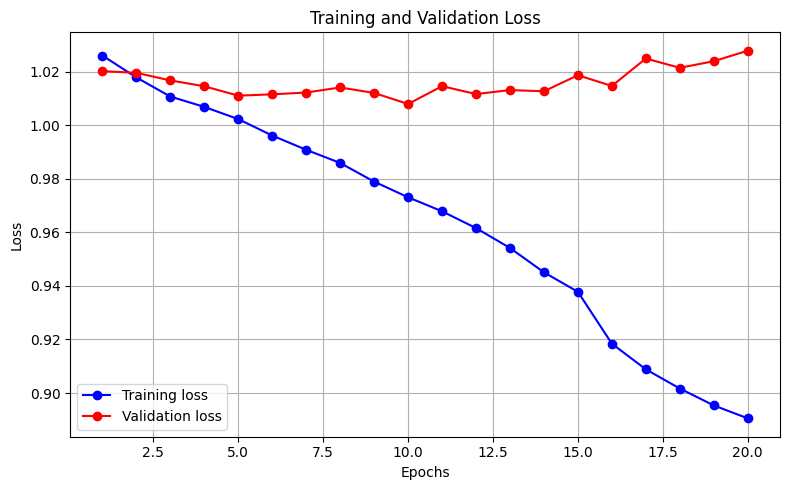

In [43]:
# Lấy giá trị loss và val_loss từ lịch sử huấn luyện
loss = lstm_history.history['loss']
val_loss = lstm_history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
input_shape = (5, len(features))  # Cập nhật len(features) với số lượng đặc trưng của bạn
lstm_model = build_lstm_model(input_shape) # Build model
lstm_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 5, 39)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 5, 50)          │        18,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,603 (170.32 KB)

 Trainable params: 43,603 (170.32 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
lstm_model.load_weights("/content/drive/MyDrive/thacsi/LuanVan/PredictStock/TA/v1/best_lstm_model_v2.keras")

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 


In [46]:
y_train_oh = to_categorical(y_train, num_classes=3)
y_test_oh = to_categorical(y_test, num_classes=3)

In [50]:
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test, y_test_oh, verbose=1)
print(f"LSTM Loss: {lstm_loss:.4f}")
print(f"LSTM Accuracy: {lstm_accuracy:.4f}")

183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5991 - loss: 0.9491
LSTM Loss: 0.9451
LSTM Accuracy: 0.6063


In [51]:
# Nếu output là xác suất (sử dụng softmax), cần lấy chỉ số nhãn lớn nhất
y_pred_probs_lstm = lstm_model.predict(X_test)
y_pred_lstm = np.argmax(y_pred_probs_lstm, axis=1)  # Chọn lớp có xác suất cao nhất

183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


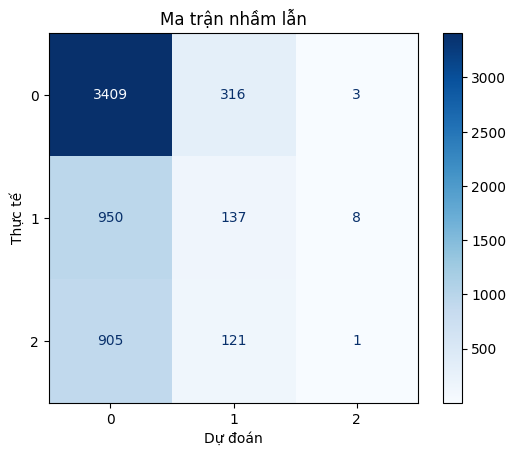

In [52]:
# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred_lstm)

# Hiển thị ma trận nhầm lẫn
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap='Blues')
plt.title('Ma trận nhầm lẫn')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.show()

In [53]:
print(classification_report(y_test, y_pred_lstm, target_names=['Hold (0)', 'Buy (1)', 'Sell (2)']))

              precision    recall  f1-score   support

    Hold (0)       0.65      0.91      0.76      3728
     Buy (1)       0.24      0.13      0.16      1095
    Sell (2)       0.08      0.00      0.00      1027

    accuracy                           0.61      5850
   macro avg       0.32      0.35      0.31      5850
weighted avg       0.47      0.61      0.51      5850



In [ ]:
# =================================================Hybrid Model========================================================

In [27]:
input_shape = (5, len(features))  # Cập nhật len(features) với số lượng đặc trưng của bạn
model = build_model(input_shape) # Build model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 39)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn (RNN)                       │ (None, 5, 64)          │         6,594 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 5, 100)         │        46,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100)            │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,397 (482.02 KB)

 Trainable params: 123,397 (482.02 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

checkpoint_cb = ModelCheckpoint("/content/drive/MyDrive/thacsi/LuanVan/PredictStock/TA/v1/best_model_v2.keras", monitor='val_loss', save_best_only=True, mode='min', verbose=1)

lr_schedule_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)


In [30]:
# Huấn luyện mô hình
history = model.fit(
    X_train, tf.keras.utils.to_categorical(y_train),
    epochs=100,
    batch_size=64,
    validation_data=(X_val, tf.keras.utils.to_categorical(y_val)),
    callbacks=[early_stopping, checkpoint_cb, lr_schedule_cb]
)

Epoch 1/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4913 - loss: 1.0422
Epoch 1: val_loss improved from inf to 1.02944, saving model to /content/drive/MyDrive/thacsi/LuanVan/PredictStock/TA/v1/best_model_v2.keras
354/354 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.4913 - loss: 1.0422 - val_accuracy: 0.4954 - val_loss: 1.0294 - learning_rate: 0.0010
Epoch 2/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4996 - loss: 1.0242
Epoch 2: val_loss improved from 1.02944 to 1.02434, saving model to /content/drive/MyDrive/thacsi/LuanVan/PredictStock/TA/v1/best_model_v2.keras
354/354 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.4996 - loss: 1.0242 - val_accuracy: 0.4929 - val_loss: 1.0243 - learning_rate: 0.0010
Epoch 3/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4952 - loss: 1.0229
Epoch 3: val_loss improved from 1.02434 to 1.02346, saving model to /content/drive/MyDrive/thacsi/LuanVan/PredictStock/TA/v1/best_model_v2.keras
354/354 ━━━━━━━━━━━

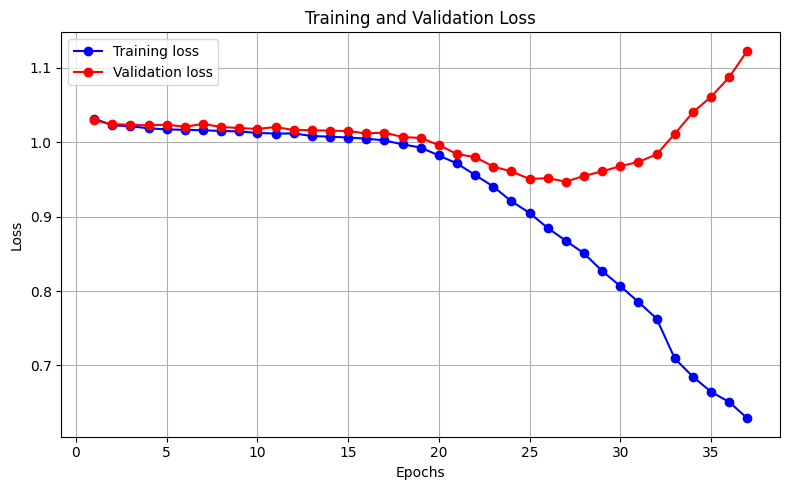

In [31]:
# Lấy giá trị loss và val_loss từ lịch sử huấn luyện
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
input_shape = (5, len(features))  # Cập nhật len(features) với số lượng đặc trưng của bạn
model = build_model(input_shape) # Build model
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 5, 39)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_1 (RNN)                     │ (None, 5, 64)          │         6,594 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 100)         │        46,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 100)            │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,397 (482.02 KB)

 Trainable params: 123,397 (482.02 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model.load_weights("/content/drive/MyDrive/thacsi/LuanVan/PredictStock/TA/v1/best_model_v2.keras")

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 


In [34]:
y_train_oh = to_categorical(y_train, num_classes=3)
y_test_oh = to_categorical(y_test, num_classes=3)

In [35]:
loss, accuracy = model.evaluate(X_test, y_test_oh, verbose=1)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5606 - loss: 1.0372
Loss: 1.0569
Accuracy: 0.5564


In [36]:
# Nếu output là xác suất (sử dụng softmax), cần lấy chỉ số nhãn lớn nhất
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Chọn lớp có xác suất cao nhất

183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


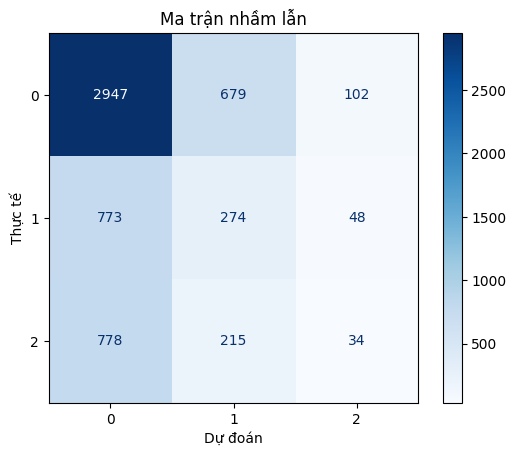

In [37]:
# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)

# Hiển thị ma trận nhầm lẫn
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap='Blues')
plt.title('Ma trận nhầm lẫn')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.show()

In [38]:
print(classification_report(y_test, y_pred, target_names=['Hold (0)', 'Buy (1)', 'Sell (2)']))

              precision    recall  f1-score   support

    Hold (0)       0.66      0.79      0.72      3728
     Buy (1)       0.23      0.25      0.24      1095
    Sell (2)       0.18      0.03      0.06      1027

    accuracy                           0.56      5850
   macro avg       0.36      0.36      0.34      5850
weighted avg       0.49      0.56      0.51      5850

